In [4]:
# Standard libraries
import torch
import pandas as pd
import requests
from PIL import Image
import numpy as np
import os

# AI/ML libraries
import clip # The library we just installed
from ultralytics import YOLO

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

print("Libraries imported.")

# Device setup for M1 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("MPS not found, using CPU")

Libraries imported.
Using MPS (Apple Silicon GPU)


In [8]:
pip install certifi


You should consider upgrading via the '/Users/ravinder/Desktop/flickd-hackathon/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:

# Cell 2: Load Models (YOLO and CLIP)

# --- Load YOLO Model ---
YOLO_MODEL_PATH = '../models/best.pt'
yolo_model = YOLO(YOLO_MODEL_PATH)
yolo_model.to(device)
print("YOLOv8 model loaded.")
import ssl
import certifi
import urllib.request


# Use certifi's certificate bundle
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(
    urllib.request.build_opener(
        urllib.request.HTTPSHandler(context=ssl_context)
    )
)

# No
# --- Load CLIP Model ---
# This will download the model the first time you run it.
# 'ViT-B/32' is a good balance of speed and performance.
clip_model, preprocess = clip.load("ViT-B/32", device=device)
print("CLIP model ViT-B/32 loaded.")

YOLOv8 model loaded.


100%|███████████████████████████████████████| 338M/338M [01:37<00:00, 3.62MiB/s]


CLIP model ViT-B/32 loaded.


Getting a test crop from product: Alexa|Trucotton V-Neck Sleeveless Boxy Top

0: 640x448 1 shirt, 201.2ms
Speed: 10.5ms preprocess, 201.2ms inference, 37.3ms postprocess per image at shape (1, 3, 640, 448)
Successfully cropped the largest detected item: 'shirt' with confidence 0.81


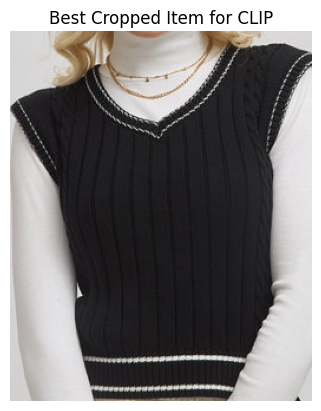

In [24]:
CATALOG_PATH = '../data/catalog_full.csv'
df_catalog = pd.read_csv(CATALOG_PATH)

# Let's use an index that we know works. Change if needed.
test_product_index = 700 
test_product = df_catalog.iloc[test_product_index]
image_url = test_product['image_url']

print(f"Getting a test crop from product: {test_product['title']}")

# Download and run YOLO
try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()
    test_image = Image.open(response.raw).convert("RGB")
    results = yolo_model(test_image)

    # --- NEW LOGIC: Find the best box (the one with the largest area) ---
    best_box = None
    max_area = 0

    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            # Calculate the area of the box
            x1, y1, x2, y2 = box.xyxy[0]
            area = (x2 - x1) * (y2 - y1)
            
            # If this box is bigger than the biggest one we've seen so far, it's our new best
            if area > max_area:
                max_area = area
                best_box = box
    # --- END OF NEW LOGIC ---

    if best_box is not None:
        # We found a best box, now let's crop it
        x1, y1, x2, y2 = map(int, best_box.xyxy[0])
        class_name = yolo_model.names[int(best_box.cls)]
        confidence = float(best_box.conf)
        
        # Crop the item from the original image
        cropped_image = test_image.crop((x1, y1, x2, y2))

        print(f"Successfully cropped the largest detected item: '{class_name}' with confidence {confidence:.2f}")
        
        # Display the cropped image
        plt.imshow(cropped_image)
        plt.title("Best Cropped Item for CLIP")
        plt.axis('off')
        plt.show()

    else:
        print("YOLO did not detect any items in this image. Please try another index.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

In [11]:

if 'cropped_image' in locals():
    # Step 1: Preprocess the image
    # The 'preprocess' function resizes, normalizes, and converts the image to a tensor.
    image_input = preprocess(cropped_image).unsqueeze(0).to(device)
    print(f"Preprocessed image tensor shape: {image_input.shape}")

    # Step 2: Get the embedding
    # We run this in a 'no_grad' block because we are not training the model.
    with torch.no_grad():
        # The model returns image features (the embedding)
        image_features = clip_model.encode_image(image_input)

    # Step 3: Normalize the features (standard practice for cosine similarity)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    print("\nSuccessfully generated CLIP embedding!")
    print(f"Embedding shape: {image_features.shape}")
    print("This is a 512-dimension vector, as expected.")
    
    # Let's look at the first 10 values of our new embedding
    print("\nFirst 10 values of the embedding vector:")
    print(image_features[0, :10].cpu().numpy())

else:
    print("Skipping embedding generation because no item was cropped.")


Preprocessed image tensor shape: torch.Size([1, 3, 224, 224])

Successfully generated CLIP embedding!
Embedding shape: torch.Size([1, 512])
This is a 512-dimension vector, as expected.

First 10 values of the embedding vector:
[  0.0095901     0.01651 -0.00052214   0.0014114   -0.031677    0.038513    0.014236    0.016968    0.022873 -0.00072336]
